## Lung and Colon Histopathology Classification using EfficientNetB7


The aim of this notebook is to create a classification model that can detect carcinomas in histopathological images.

The model is trained on the Lung and Colon Cancer Histopathological Images dataset [Lung and Colon Cancer Histopathological Images] and can distinguish between different classes: `Benign`, `Adenocarcinoma`, `Squamous Cell Carcinoma`.

The purpose of this decision is to create a model that can diagnose cancer regardless of the organ where the sample is taken from.

## Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import cv2
import time
import itertools

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7 as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

print('Modules loaded')

Mounted at /content/drive
Modules loaded


## Helper Functions

In [ ]:
# Generate data paths with labels
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        flist = os.listdir(foldpath)

        for f in flist:
            f_path = os.path.join(foldpath, f)
            filelist = os.listdir(f_path)

            for file in filelist:
                fpath = os.path.join(f_path, file)
                filepaths.append(fpath)

                if f == 'colon_aca':
                    labels.append('Colon Adenocarcinoma')

                elif f == 'colon_n':
                    labels.append('Colon Benign Tissue')

                elif f == 'lung_aca':
                    labels.append('Lung Adenocarcinoma')

                elif f == 'lung_n':
                    labels.append('Lung Benign Tissue')

                elif f == 'lung_scc':
                    labels.append('Lung Squamous Cell Carcinoma')

    return filepaths, labels


# Concatenate data paths with labels into one dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split data into training, validation, and test dataframes in 80:10:10 ratio
def split_data(data_dir):
    # training dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)


    # validation and test dataframe
    strat = df['labels']
    train_df, remaining_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=123, stratify=strat)
    valid_df, test_df = train_test_split(remaining_df, train_size=0.5, shuffle=True, random_state=123, stratify=remaining_df['labels'])

    return train_df, valid_df, test_df

# Show sample of the images from the data generator
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

## Loading Data

In [ ]:
from glob import glob

data_dir = '/content/drive/MyDrive/new_folder'
if os.path.exists(data_dir):
    print("Directory exists:", data_dir)
else:
    print("Directory does not exist:", data_dir)
print(data_dir)
image_files = glob(data_dir + '/*/*/*.jpeg')
print('Images Count: ', len(image_files))


Directory exists: /content/drive/MyDrive/new_folder
/content/drive/MyDrive/new_folder
Images Count:  5000


In [ ]:
# Split data into training, validation, and test dataframes in 80:10:10 ratio
train_df, valid_df, test_df = split_data(data_dir)

In [ ]:
# define model parameters

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
img_size = (224, 224)
batch_size = 32
color = 'rgb'

# training data augmentation
tr_gen = ImageDataGenerator(horizontal_flip= True)
ts_gen = ImageDataGenerator()

# creating data generators from the dataframes

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle = True, batch_size= batch_size, data_format='channels_first')

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle = True, batch_size= batch_size, data_format='channels_first')

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle = False, batch_size= batch_size, data_format='channels_first')

Found 3000 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.


In [ ]:
train_df.head()

filepaths  \
4363  /content/drive/MyDrive/new_folder/colon_image_...   
1066  /content/drive/MyDrive/new_folder/lung_image_s...   
2800  /content/drive/MyDrive/new_folder/lung_image_s...   
817   /content/drive/MyDrive/new_folder/lung_image_s...   
3671  /content/drive/MyDrive/new_folder/colon_image_...   

                            labels  
4363           Colon Benign Tissue  
1066  Lung Squamous Cell Carcinoma  
2800           Lung Adenocarcinoma  
817             Lung Benign Tissue  
3671          Colon Adenocarcinoma

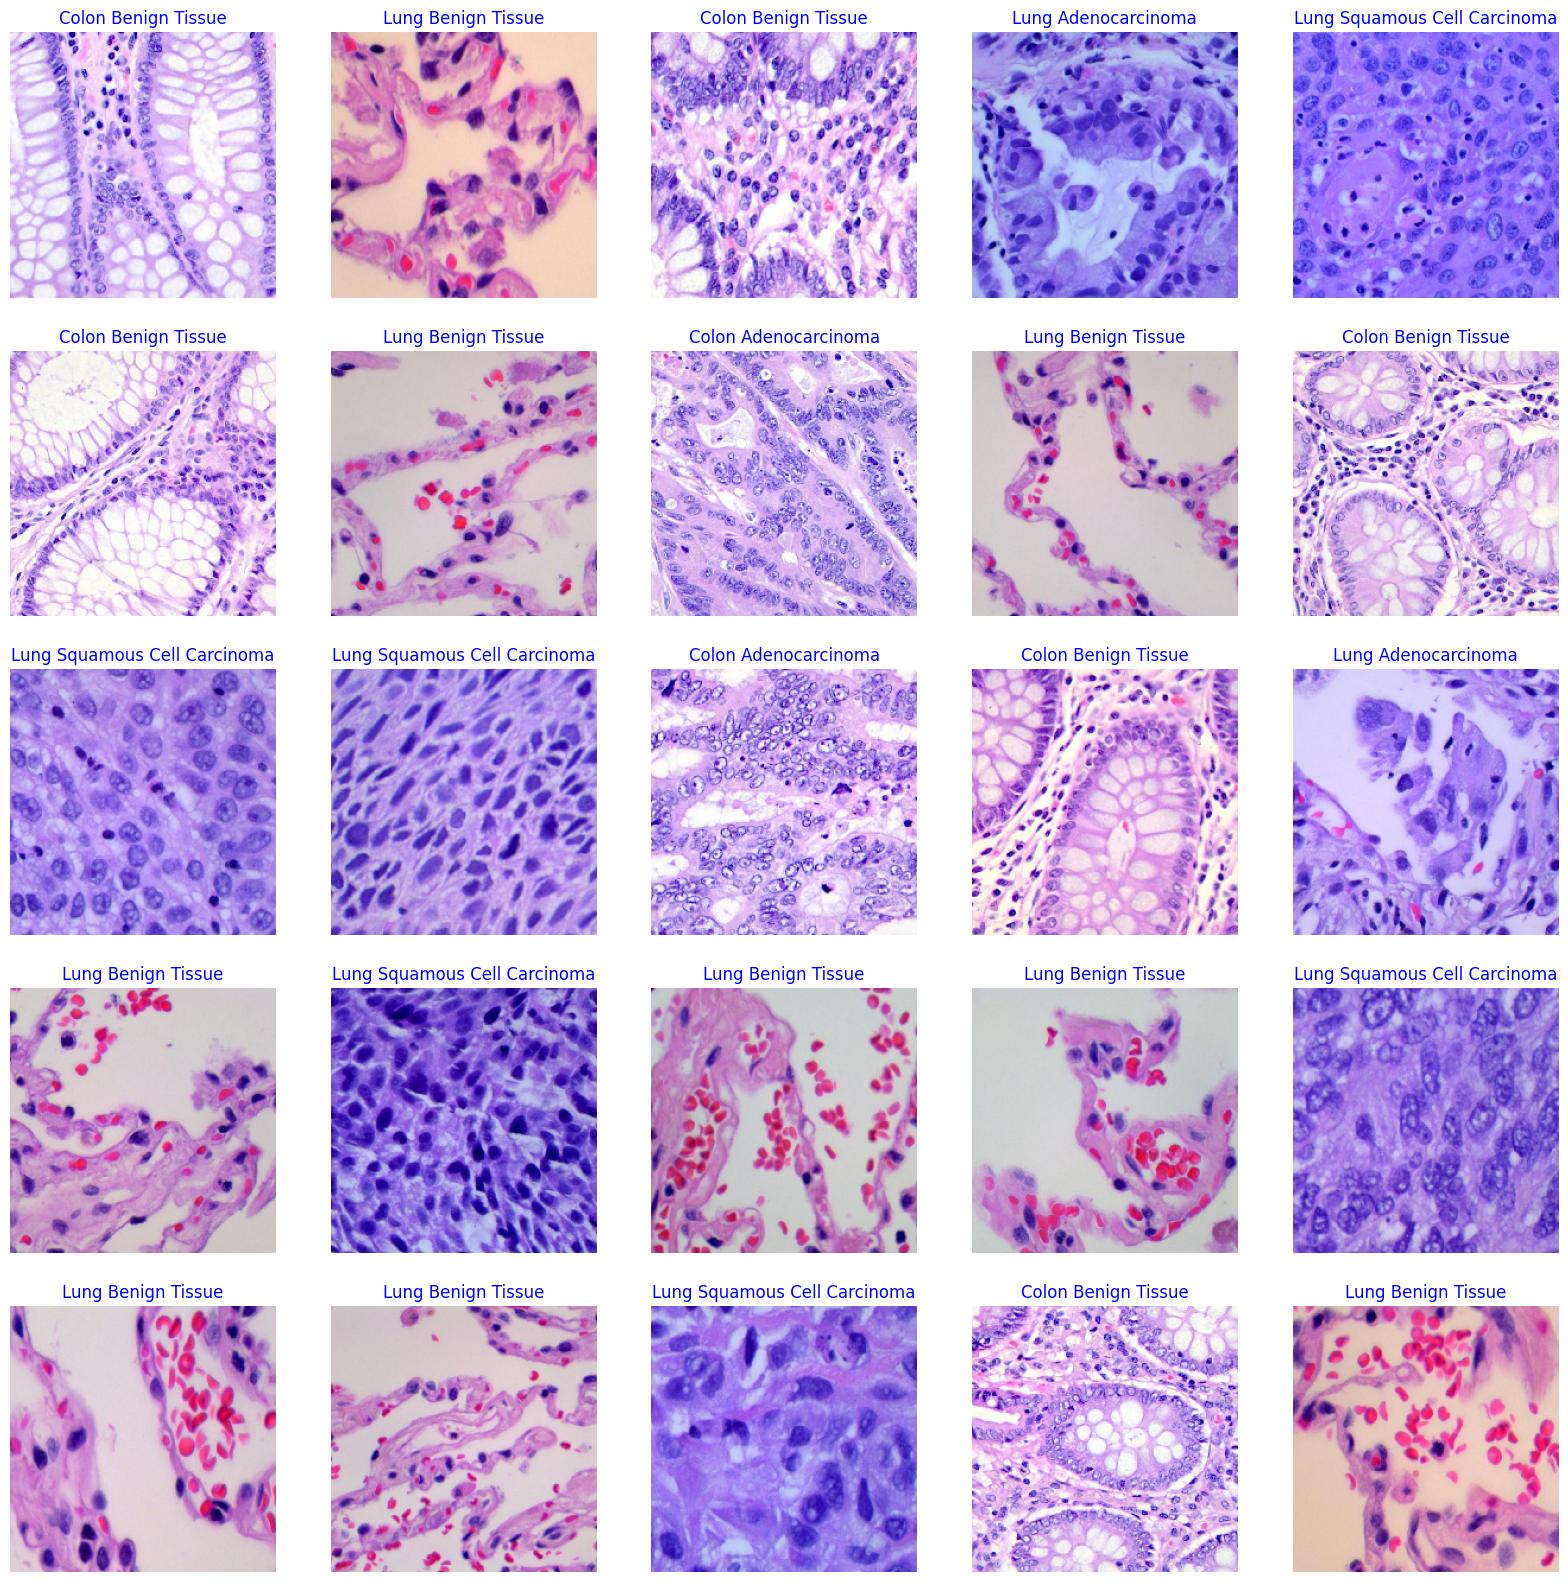

In [ ]:
# displaying image samples
show_images(train_gen)

## Model Building

In [ ]:
base_model = PretrainedModel( #EfficientNetB7
    input_shape=(img_size[0], img_size[1], 3),
    weights='imagenet',
    include_top=False)

base_model.trainable = False

K = len(list(train_gen.class_indices.keys()))

x = GlobalAveragePooling2D()(base_model.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
y = Dense(K, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=y)

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=15,
    shuffle= False,
    callbacks=[early_stopping])

Epoch 1/15


## Model Evaluation and Results Visualization


In [ ]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

In [ ]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [ ]:
#   predict class labels for test data
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

In [ ]:
# function for plotting confusion matrix
def plot_confusion_matrix(cm, classes, title= 'Normalized Confusion Matrix', cmap= plt.cm.Blues):

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
    print('\nNormalized Confusion Matrix')
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')